# Data download

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lux 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/olist_order_payments_dataset.csv
./data/olist_sellers_dataset.csv
./data/olist_order_reviews_dataset.csv
./data/olist_order_items_dataset.csv
./data/olist_orders_dataset.csv
./data/olist_geolocation_dataset.csv
./data/olist_products_dataset.csv
./data/olist_customers_dataset.csv
./data/product_category_name_translation.csv


In [3]:
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
items = pd.read_csv("./data/olist_order_items_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")

## Merge datasets

In [4]:
datasets = [customers, sellers, reviews, items, products, geolocation, category_name_translation, orders, order_payments]

In [5]:
df = orders.merge(items, on="order_id").merge(products, on = "product_id").merge(sellers, on="seller_id").merge(customers, on="customer_id")

In [6]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

# Data cleaning

In [7]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df['expected_delivery_timedelta'] = pd.to_numeric(df['order_estimated_delivery_date']- df["order_purchase_timestamp"])
df['delivery_time'] = pd.to_numeric(df["order_delivered_customer_date"] - df['order_purchase_timestamp'])

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [8]:
#df.drop(["expected_delivery_timedelta"], axis = 1, inplace=True)

In [9]:
df

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/vislib/altair/Histogram.py:47: RuntimeWarning:overflow encountered in long_scalars


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [10]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

## Detecting outliers in numerical data

In [11]:
unique_orders_count = df.groupby(["customer_id"])["order_id"].count() # Count unique orders
nof_moest_popular_sales = df.groupby(["customer_id"])["seller_id"].agg(lambda x:x.value_counts()[0]) # Number of orders from most popular sellers
max_sale = df.groupby(["customer_id"])["price"].max() # Most money spent on single order
median_sale = df.groupby(["customer_id"])["price"].median() # Median money spent on orders
sum_sale = df.groupby(["customer_id"])["price"].sum() # Median money spent on orders

median_volume = df.groupby(["customer_id"])["product_volume"].median() # Median volume of products in orders
max_volume = df.groupby(["customer_id"])["product_volume"].max() # Median money spent on orders

average_delivery_time = df.groupby(["customer_id"])["delivery_time"].max() # Average delivery time
average_expected_delivery_time = df.groupby(["customer_id"])["expected_delivery_timedelta"].max() # Average delivery time


unique_orders_count.name = "unique_orders_count"
nof_moest_popular_sales.name = "nof_moest_popular_sales"
max_sale.name = "max_sale"
median_sale.name = "median_sale"
sum_sale.name = "sum_sale"
median_volume.name = "median_volume"
average_delivery_time.name = "average_delivery_time"
average_expected_delivery_time.name = "average_expected_delivery_time"

In [12]:
customers2 = customers.set_index("customer_id")

In [13]:
customers2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [14]:
df2 = customers2.join([unique_orders_count, nof_moest_popular_sales, max_sale, median_sale, sum_sale, median_volume, average_delivery_time,average_expected_delivery_time],  how="outer")

In [15]:
df2[df2["unique_orders_count"] > 1]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [16]:
cat_attributes = ["customer_city", "customer_state"]
num_attributes = ["unique_orders_count", "nof_moest_popular_sales", "max_sale", "median_sale", "sum_sale", "median_volume", "average_delivery_time","average_expected_delivery_time"]

In [17]:
df2['average_expected_delivery_time'] = df2['average_expected_delivery_time']
df2['average_delivery_time'] = df2['average_delivery_time']

In [18]:
df2.fillna(df2.mean(), inplace=True)

In [19]:
df2.info()

<class 'lux.core.frame.LuxDataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              99441 non-null  object 
 1   customer_zip_code_prefix        99441 non-null  int64  
 2   customer_city                   99441 non-null  object 
 3   customer_state                  99441 non-null  object 
 4   unique_orders_count             99441 non-null  float64
 5   nof_moest_popular_sales         99441 non-null  float64
 6   max_sale                        99441 non-null  float64
 7   median_sale                     99441 non-null  float64
 8   sum_sale                        99441 non-null  float64
 9   median_volume                   99441 non-null  float64
 10  average_delivery_time           99441 non-null  float64
 11  average_expected_delivery_time  99441 no

In [20]:
df2.groupby("customer_city")["customer_state"].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [21]:
groupby_col="customer_city"

In [22]:
other_countes = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[21:,:].reset_index()[groupby_col].array

In [23]:
df2.loc[df2.customer_city.isin(other_countes), "customer_city"] = "other"

In [24]:
df2.customer_city.nunique()

22

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df2)
df_prepared

<99441x57 sparse matrix of type '<class 'numpy.float64'>'
	with 991310 stored elements in Compressed Sparse Row format>

In [26]:
df3 = df_prepared.toarray()

In [27]:
len(num_attributes)

8

In [28]:
import lux
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# HDBSCAN

In [79]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=600, min_samples=80, cluster_selection_epsilon=0.6)

In [83]:
#clusterer.fit(df3[np.random.choice(df3.shape[0],50000, replace=False),:])
clusterer.fit(df3)

HDBSCAN(cluster_selection_epsilon=0.6, min_cluster_size=600, min_samples=80)

In [84]:
max(clusterer.labels_)

29

<AxesSubplot:ylabel='Count'>

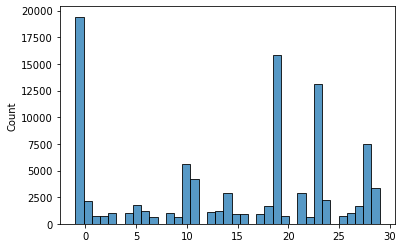

In [85]:
import seaborn as sns
sns.histplot(clusterer.labels_)

# UMAP

In [32]:
import umap

2021-08-08 08:03:31.543024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [33]:
import umap.plot

In [87]:
mapper = umap.UMAP(densmap=True).fit(df3)

<AxesSubplot:>

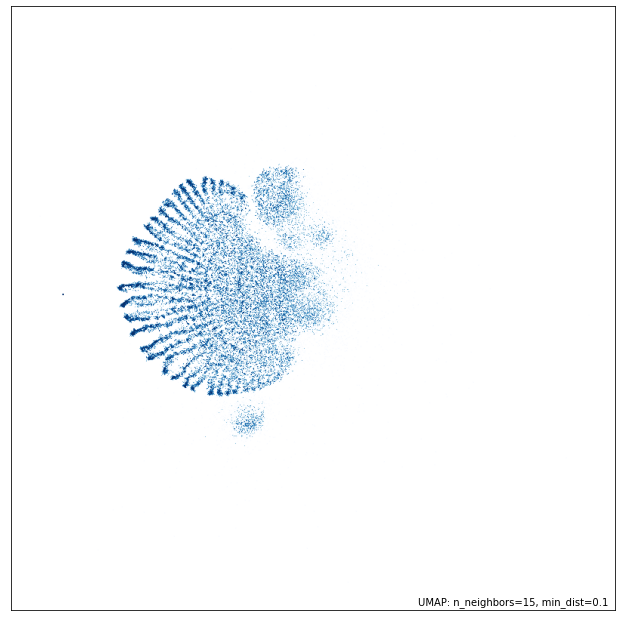

In [35]:
umap.plot.points(mapper)

## HDBSCAN viz

<AxesSubplot:>

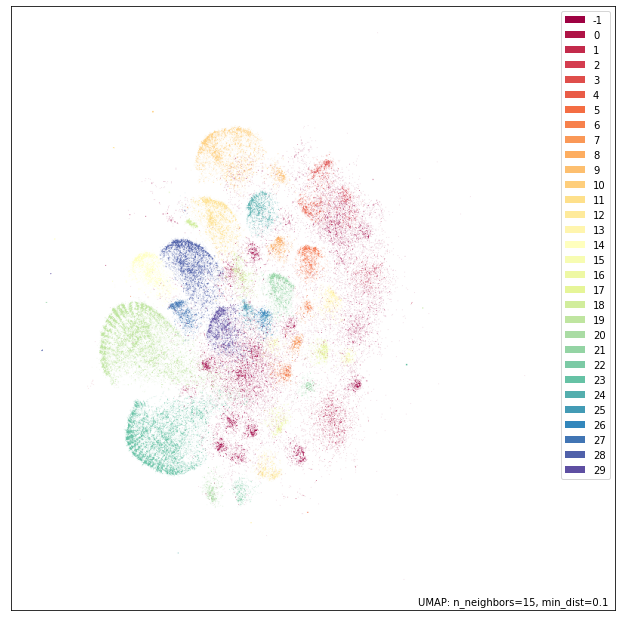

In [88]:
umap.plot.points(mapper, labels=clusterer.labels_)

In [83]:
mapper2 = umap.UMAP(densmap=True).fit(df3[np.random.choice(df3.shape[0], 10000, replace=False)])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

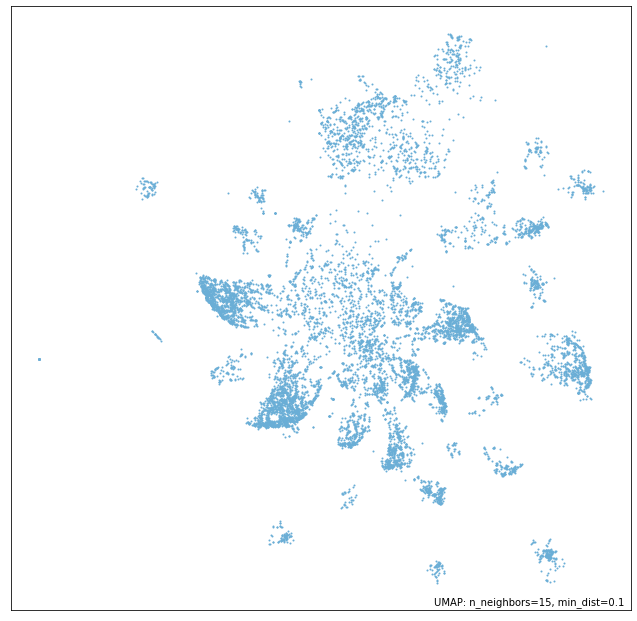

In [84]:
umap.plot.points(mapper2)

In [85]:
df3.data

In [86]:
df3.shape

(99441, 57)

In [87]:
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# KMEANS

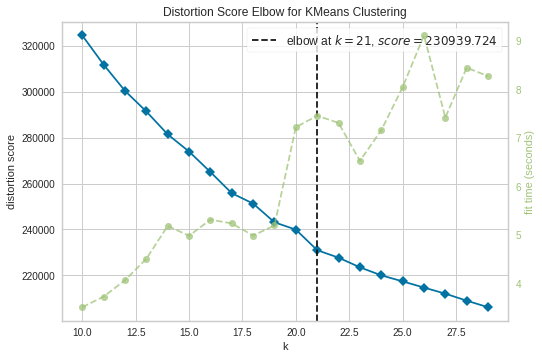

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()

visualizer = KElbowVisualizer(model, k=(10,30), timings=True)
visualizer.fit(df3)
visualizer.show()

In [91]:
X = df3
kmeans = KMeans(n_clusters=21, random_state=0, copy_x=False, precompute_distances=False).fit(X)

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:786: FutureWarning:'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect


In [92]:
kmeans.labels_

array([ 4, 15, 15, ..., 20,  8, 18], dtype=int32)

<AxesSubplot:ylabel='Count'>

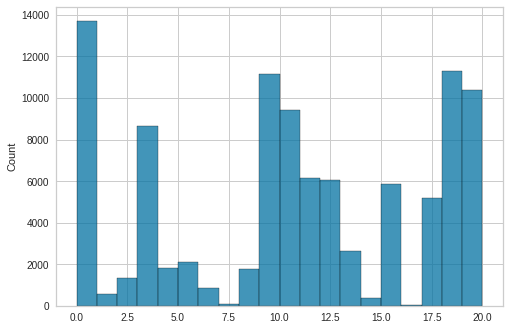

In [108]:
sns.histplot(kmeans.labels_, bins=max(kmeans.labels_))

## Kmeans viz

<AxesSubplot:>

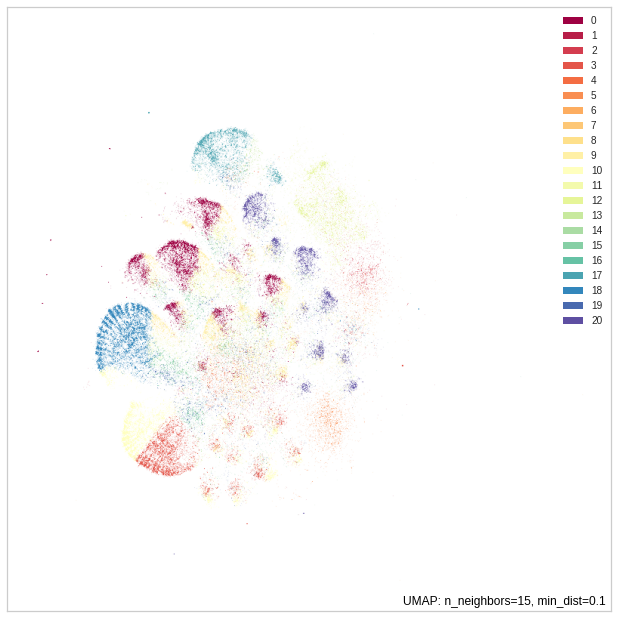

In [93]:
umap.plot.points(mapper, labels=kmeans.labels_)

In [94]:
points = mapper.embedding_

In [95]:
points[:,0]

array([ 3.3727489,  2.2081897,  1.2270601, ..., 19.58081  ,  7.0649   ,
       -8.818401 ], dtype=float32)

In [122]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<AxesSubplot:>

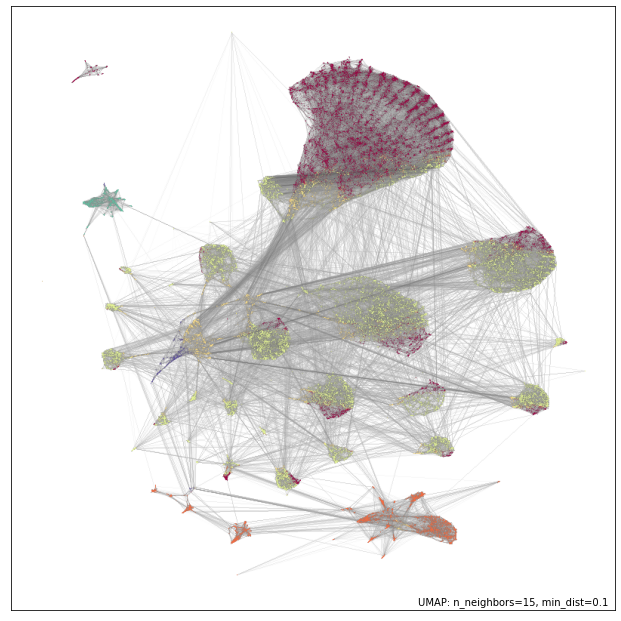

In [38]:
umap.plot.connectivity(mapper, show_points=True, labels=kmeans.labels_)

In [96]:
import seaborn as sns

In [97]:
points

array([[  3.3727489 ,   0.24475384],
       [  2.2081897 , -11.860449  ],
       [  1.2270601 ,  -4.522969  ],
       ...,
       [ 19.58081   ,   0.90831935],
       [  7.0649    ,  -2.3733265 ],
       [ -8.818401  ,   5.944895  ]], dtype=float32)

In [98]:
df2["x"] = points[:,0]
df2["y"] = points[:,1]

In [99]:
df2['y']

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [100]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

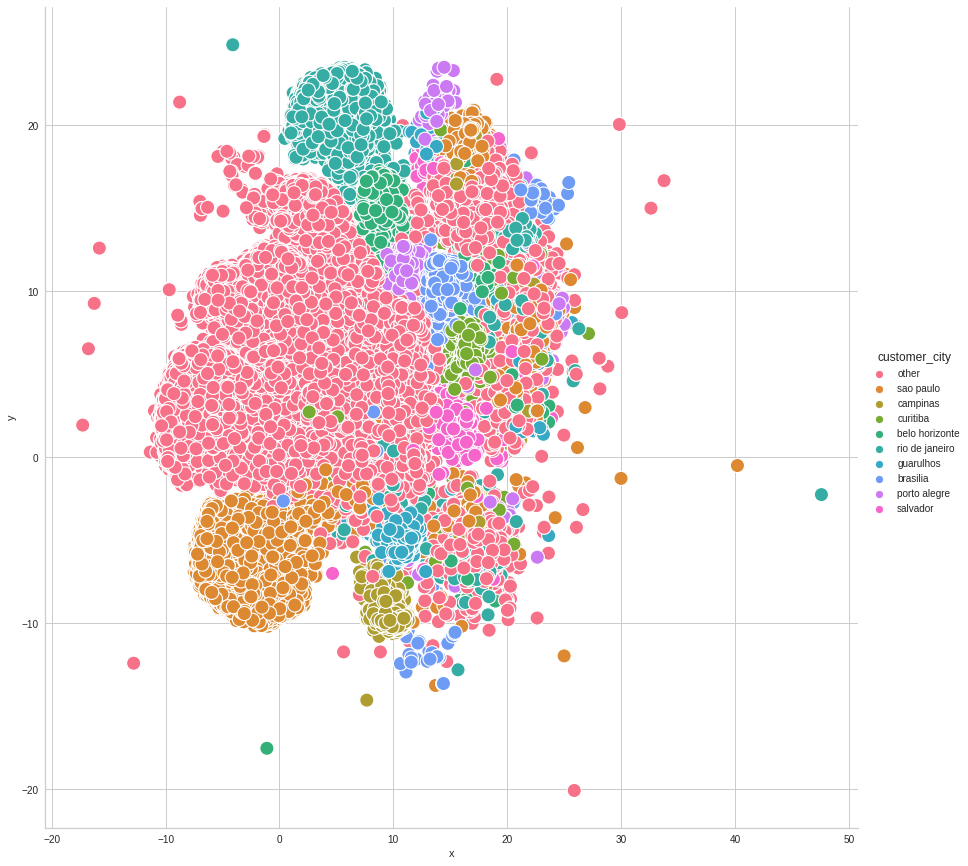

In [101]:
countries = df2.groupby('customer_city').count().sort_values('customer_state', ascending=False).iloc[0:10,:].reset_index()['customer_city'].array
sns.relplot(
    data = df2.loc[df2['customer_city'].isin(countries)],
    x = "x",
    y = "y",
    hue = 'customer_city',
    height = 12,
    s=200)

In [49]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y'],
      dtype='object')

In [102]:
smapper = umap.UMAP().fit_transform(X, kmeans.labels_)

<AxesSubplot:>

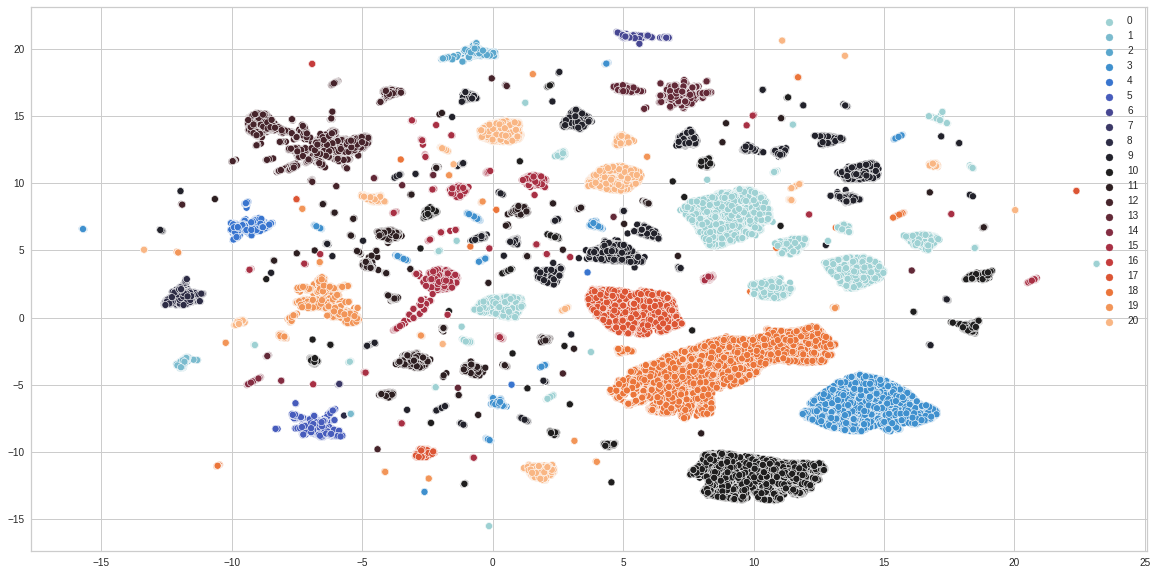

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=smapper[:,0], y=smapper[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", 21))

<AxesSubplot:>

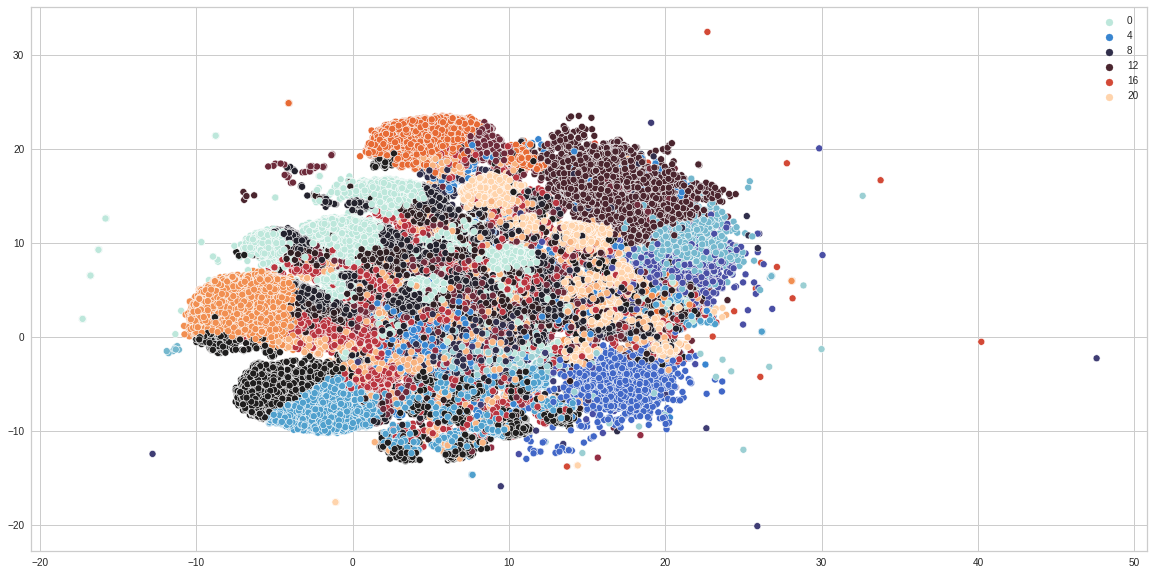

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", as_cmap=True))

In [71]:
df2['x1'] = smapper[:,0]
df2['y1'] = smapper[:,1]

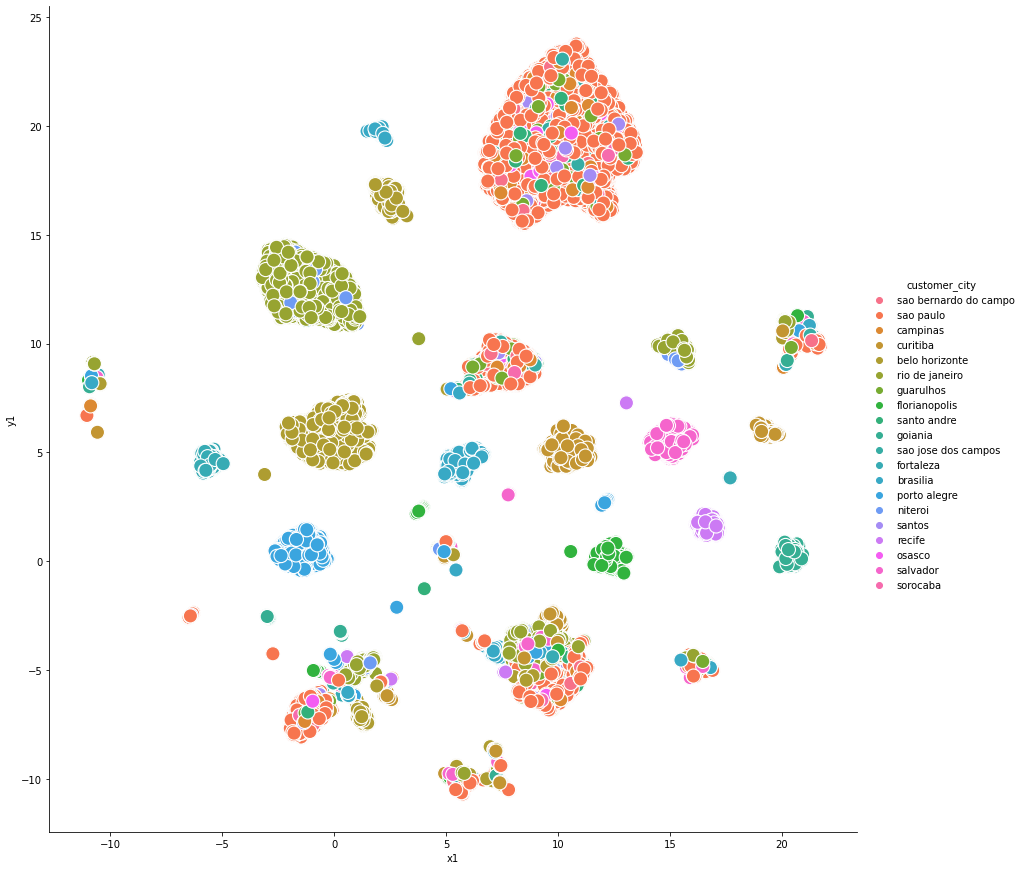

In [74]:
groupby_col="customer_city"

countries = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[0:20,:].reset_index()[groupby_col].array

sns.relplot(
    data = df2.loc[df2[groupby_col].isin(countries)],
    x = "x1",
    y = "y1",
    hue = groupby_col,
    height = 12,
    s=200)

In [76]:
df2.loc[df2[groupby_col].isin(countries)]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [125]:
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [124]:
import sklearn

In [126]:
outlier_scores

array([1, 1, 1, ..., 1, 1, 1])

In [132]:
df2['outlier'] = outlier_scores

In [133]:
df2.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

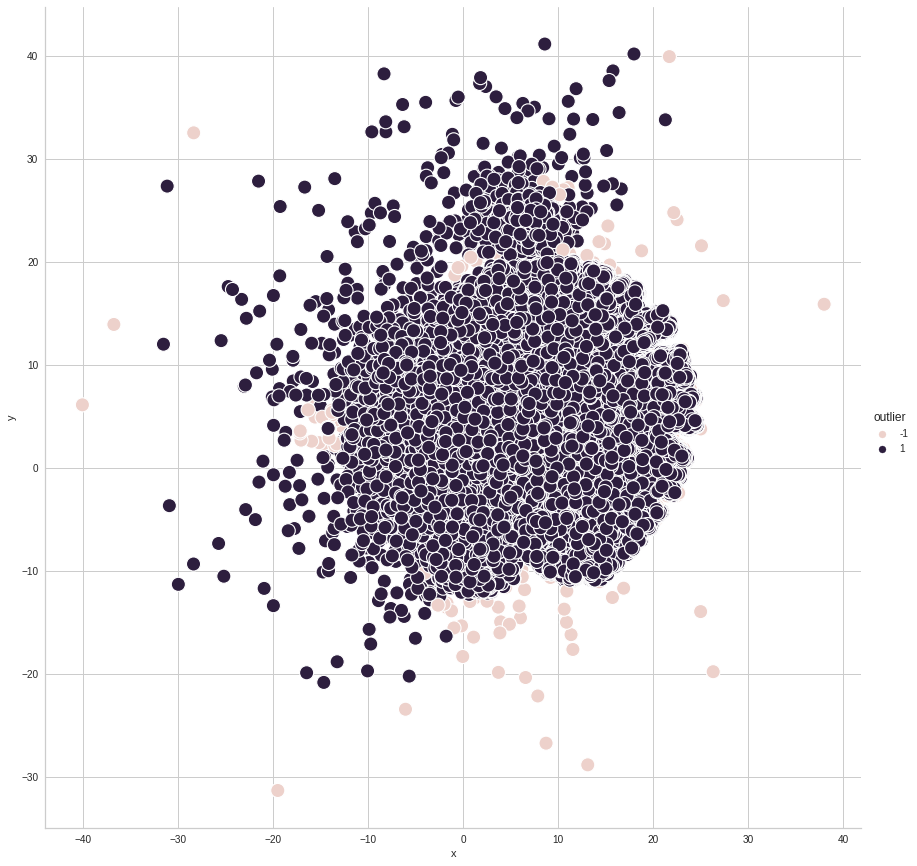

In [135]:
sns.relplot(
    data = df2,
    x = "x",
    y = "y",
    hue = "outlier",
    height = 12,
    s=200)

In [138]:
df.info(0)

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [169]:
df4 = df.merge(df2, on="customer_unique_id")

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='product_width_cm'>

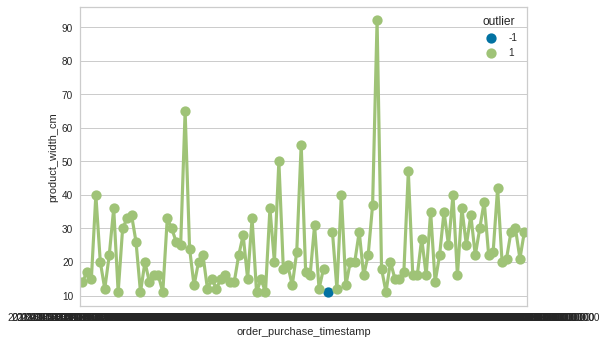

In [168]:
sns.pointplot(x="order_purchase_timestamp", y="product_width_cm", data=df4.sample(100), hue='outlier')

<AxesSubplot:xlabel='price'>

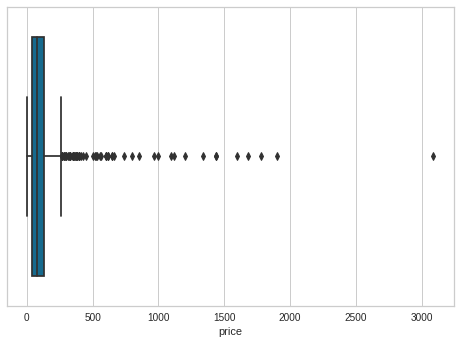

In [148]:
sns.boxplot(x="price", data=df.sample(1000))

<AxesSubplot:xlabel='product_volume'>

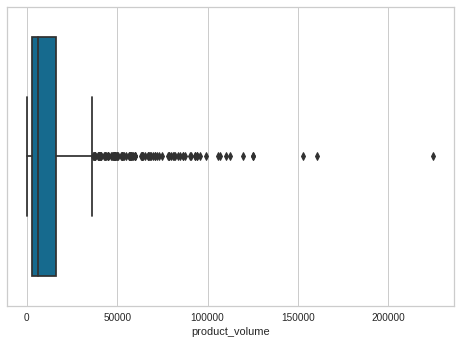

In [147]:
sns.boxplot(x="product_volume", data=df.sample(1000))

# Analizing clusters

In [115]:
df2["cluster"] = kmeans.labels_

In [117]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'clusters', 'cluster'],
      dtype='object')

<AxesSubplot:xlabel='cluster', ylabel='max_sale'>

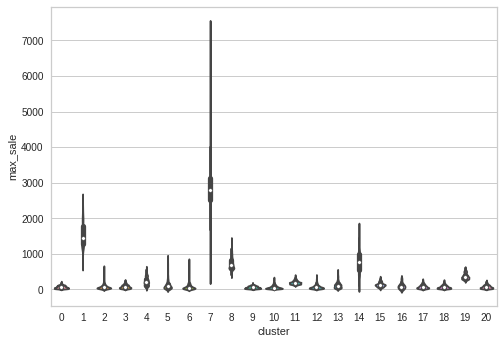

In [126]:
sns.violinplot(data=df2,x="cluster", y="max_sale")

In [124]:
# For all float columns
cols = df2.columns[df2.dtypes == "float64"]

In [128]:
import matplotlib.pyplot as plt
from pylab import *

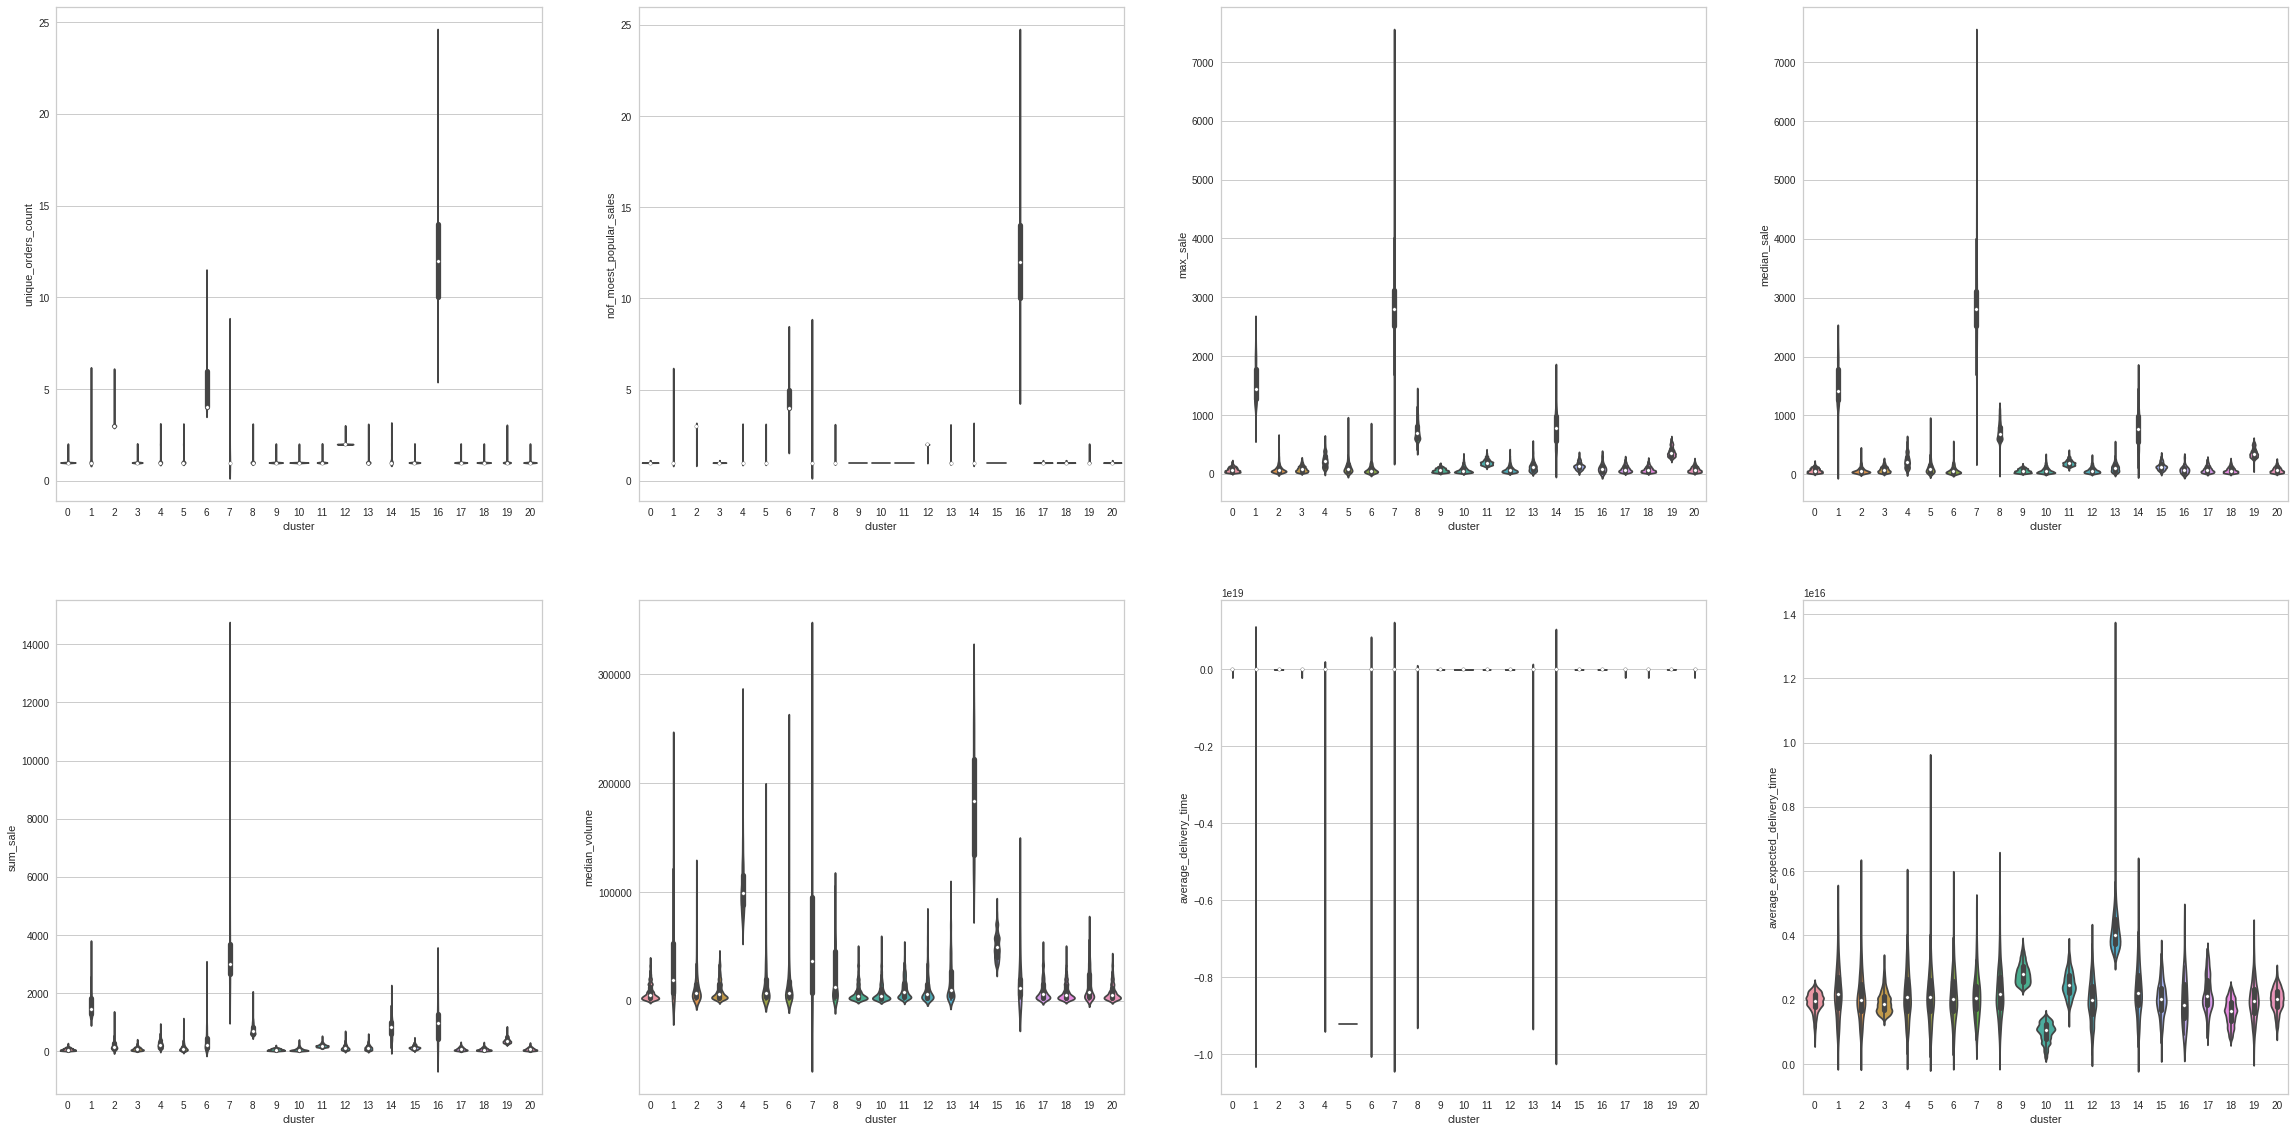

In [143]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(40,20))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(cols[i]))
    sns.violinplot(data=df2,x="cluster", y=cols[i], ax=ax)

In [144]:
df2.groupby("cluster").mean()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [145]:
df2.mean()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [146]:
# Author: YousefGh
# Source: https://github.com/YousefGh/kmeans-feature-importance

from sklearn.cluster import KMeans
import numpy as np


class KMeansInterp(KMeans):
    def __init__(self, ordered_feature_names, feature_importance_method='wcss_min', **kwargs):
        super(KMeansInterp, self).__init__(**kwargs)
        self.feature_importance_method = feature_importance_method
        self.ordered_feature_names = ordered_feature_names
        
    def fit(self, X, y=None, sample_weight=None):
        super().fit(X=X, y=y, sample_weight=sample_weight)
        
        if not len(self.ordered_feature_names) == self.n_features_in_:
            raise Exception(f"Model is fitted on {self.n_features_in_} but ordered_feature_names = {len(self.ordered_feature_names)}")
        
        if self.feature_importance_method == "wcss_min":
            self.feature_importances_ = self.get_feature_imp_wcss_min()
        elif self.feature_importance_method == "unsup2sup":
            self.feature_importances_ = self.get_feature_imp_unsup2sup(X)
        else: 
            raise Exception(f" {self.feature_importance_method}"+\
            "is not available. Please choose from  ['wcss_min' , 'unsup2sup']")
        
        return self
        
    def get_feature_imp_wcss_min(self):
        labels = self.n_clusters
        centroids = self.cluster_centers_
        centroids = np.vectorize(lambda x: np.abs(x))(centroids)
        sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

        cluster_feature_weights = {}
        for label, centroid in zip(range(labels), sorted_centroid_features_idx):
            ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
            ordered_cluster_features = [self.ordered_feature_names[feature] for feature in centroid]
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        
        return cluster_feature_weights
    
    def get_feature_imp_unsup2sup(self, X):
        try:
            from sklearn.ensemble import RandomForestClassifier
        except ImportError as IE:
            print(IE.__class__.__name__ + ": " + IE.message)
            raise Exception("Please install scikit-learn. " + 
                            "'unsup2sup' method requires using a classifier"+ 
                            "and depends on 'sklearn.ensemble.RandomForestClassifier'")
        
        cluster_feature_weights = {}
        for label in range(self.n_clusters):
            binary_enc = np.vectorize(lambda x: 1 if x == label else 0)(self.labels_)
            clf = RandomForestClassifier()
            clf.fit(X, binary_enc)

            sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
            ordered_cluster_features = np.take_along_axis(
                np.array(self.ordered_feature_names), 
                sorted_feature_weight_idxes, 
                axis=0)
            ordered_cluster_feature_weights = np.take_along_axis(
                np.array(clf.feature_importances_), 
                sorted_feature_weight_idxes, 
                axis=0)
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        return cluster_feature_weights

# KMeans Interpret

In [154]:
pipeline.transformers_[1][1].get_feature_names()

array(['x0_belo horizonte', 'x0_brasilia', 'x0_campinas', 'x0_curitiba',
       'x0_florianopolis', 'x0_fortaleza', 'x0_goiania', 'x0_guarulhos',
       'x0_jundiai', 'x0_niteroi', 'x0_osasco', 'x0_other',
       'x0_porto alegre', 'x0_recife', 'x0_rio de janeiro', 'x0_salvador',
       'x0_santo andre', 'x0_santos', 'x0_sao bernardo do campo',
       'x0_sao jose dos campos', 'x0_sao paulo', 'x0_sorocaba', 'x1_AC',
       'x1_AL', 'x1_AM', 'x1_AP', 'x1_BA', 'x1_CE', 'x1_DF', 'x1_ES',
       'x1_GO', 'x1_MA', 'x1_MG', 'x1_MS', 'x1_MT', 'x1_PA', 'x1_PB',
       'x1_PE', 'x1_PI', 'x1_PR', 'x1_RJ', 'x1_RN', 'x1_RO', 'x1_RR',
       'x1_RS', 'x1_SC', 'x1_SE', 'x1_SP', 'x1_TO'], dtype=object)

array(['unique_orders_count', 'nof_moest_popular_sales', 'max_sale',
       'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time',
       'x0_belo horizonte', 'x0_brasilia', 'x0_campinas', 'x0_curitiba',
       'x0_florianopolis', 'x0_fortaleza', 'x0_goiania', 'x0_guarulhos',
       'x0_jundiai', 'x0_niteroi', 'x0_osasco', 'x0_other',
       'x0_porto alegre', 'x0_recife', 'x0_rio de janeiro', 'x0_salvador',
       'x0_santo andre', 'x0_santos', 'x0_sao bernardo do campo',
       'x0_sao jose dos campos', 'x0_sao paulo', 'x0_sorocaba', 'x1_AC',
       'x1_AL', 'x1_AM', 'x1_AP', 'x1_BA', 'x1_CE', 'x1_DF', 'x1_ES',
       'x1_GO', 'x1_MA', 'x1_MG', 'x1_MS', 'x1_MT', 'x1_PA', 'x1_PB',
       'x1_PE', 'x1_PI', 'x1_PR', 'x1_RJ', 'x1_RN', 'x1_RO', 'x1_RR',
       'x1_RS', 'x1_SC', 'x1_SE', 'x1_SP', 'x1_TO'], dtype=object)

In [164]:
interpreter = KMeansInterp(n_clusters=21, random_state=0, copy_x=False, ordered_feature_names=np.concatenate((cols.to_numpy(), pipeline.transformers_[1][1].get_feature_names()))).fit(X)

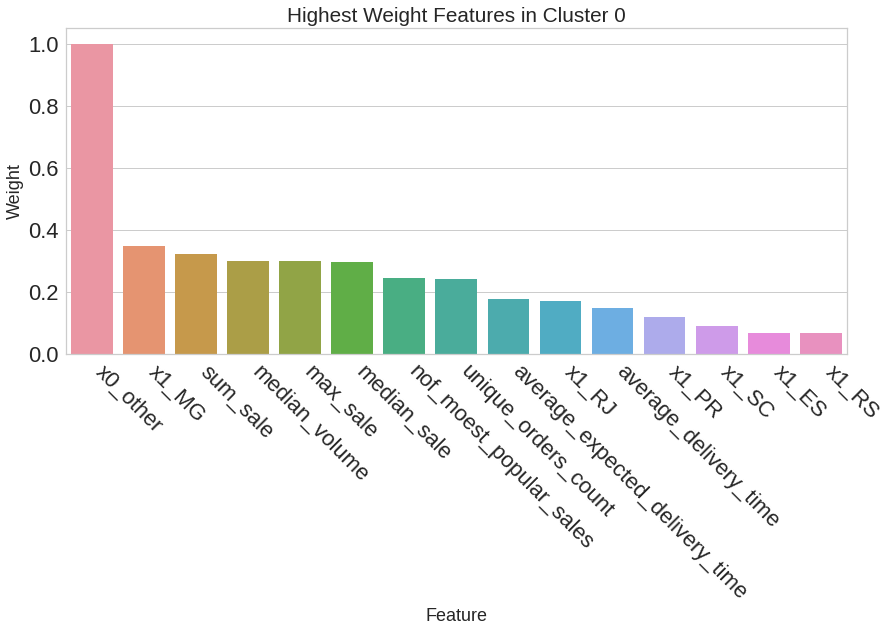

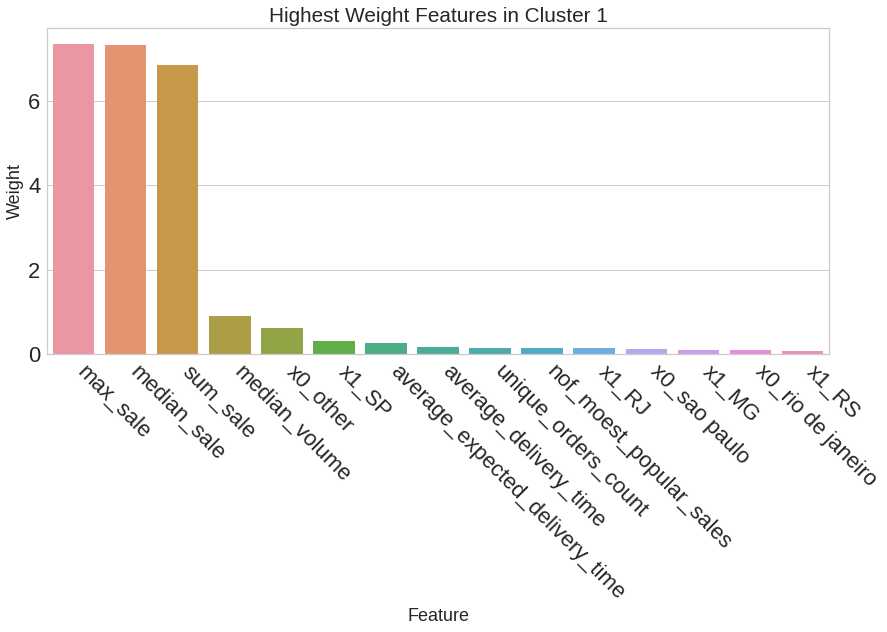

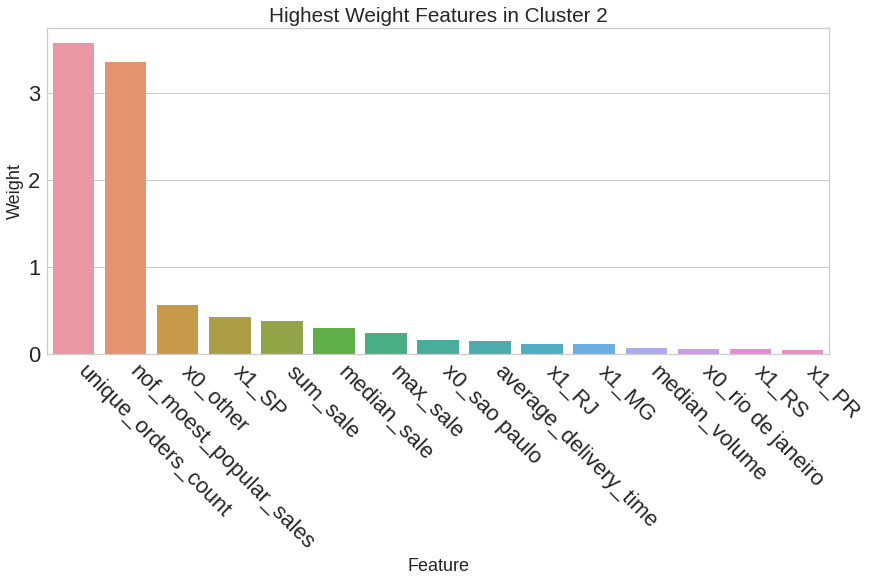

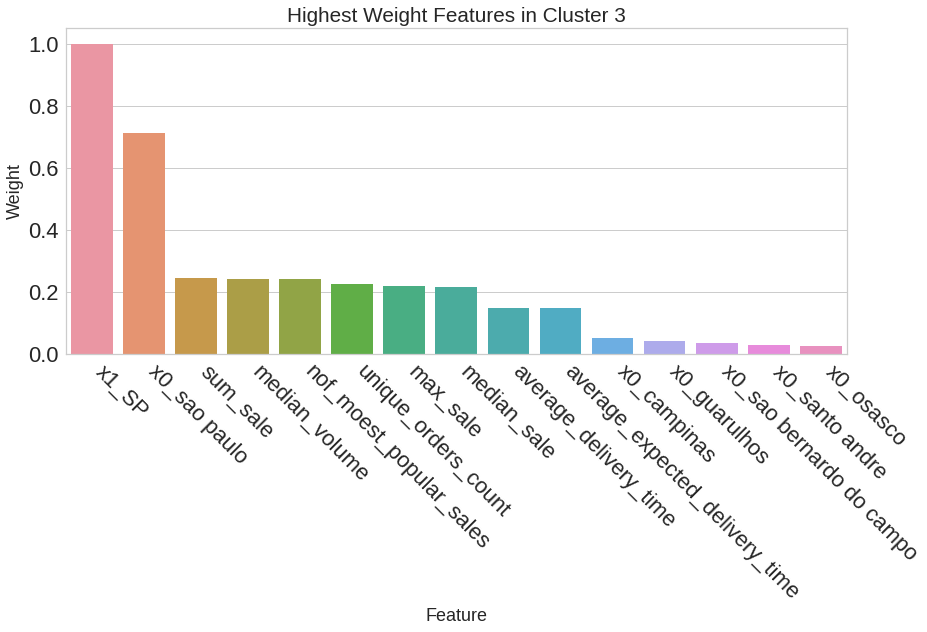

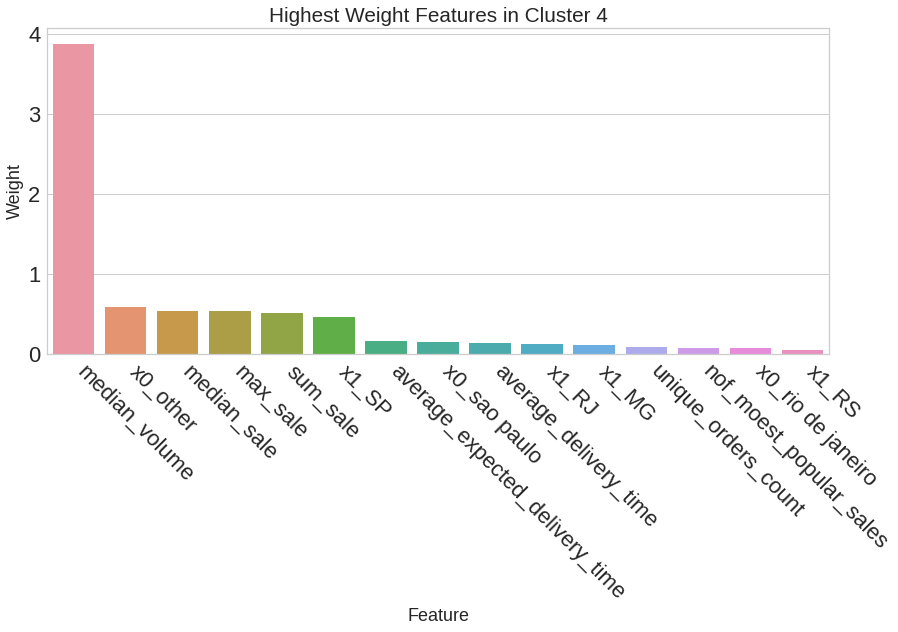

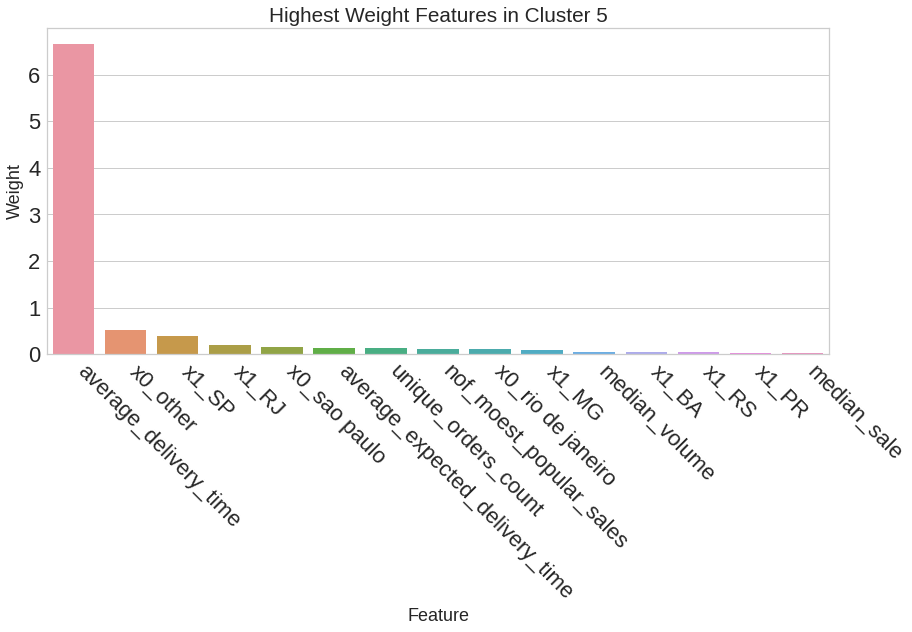

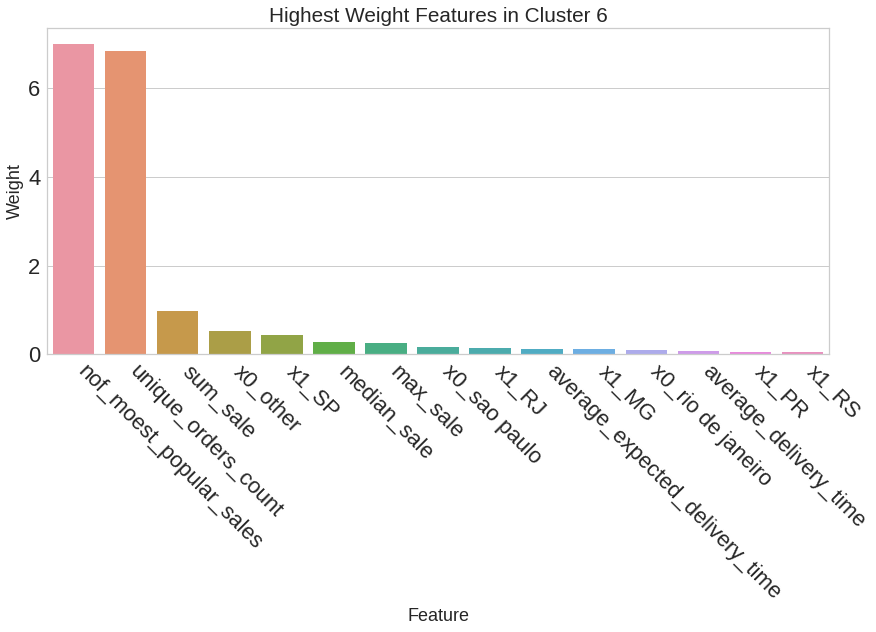

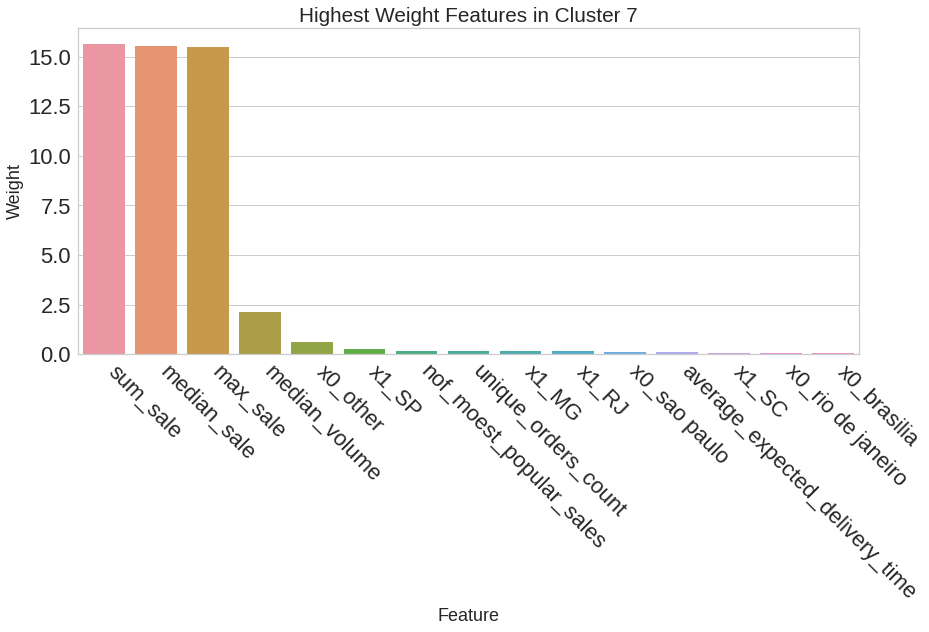

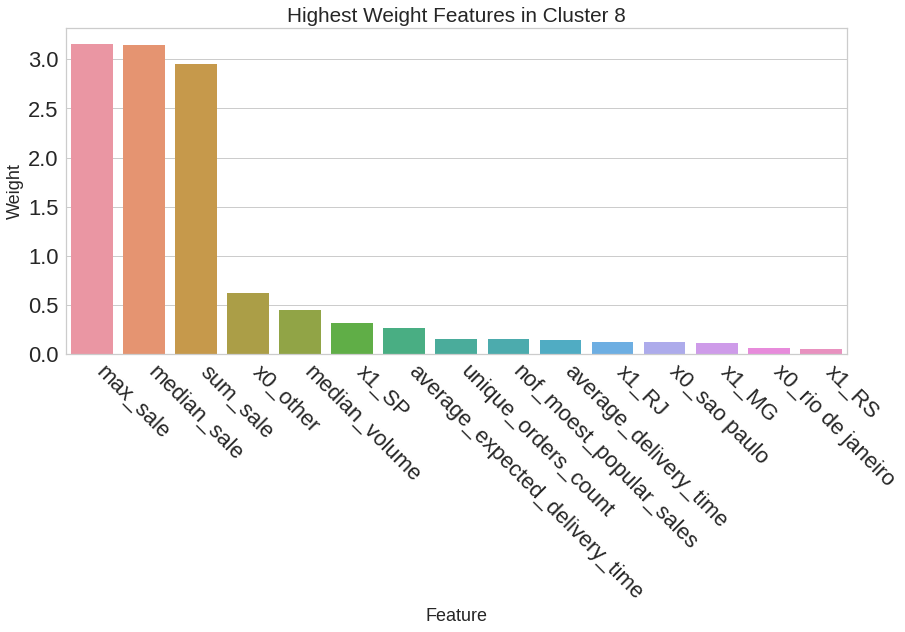

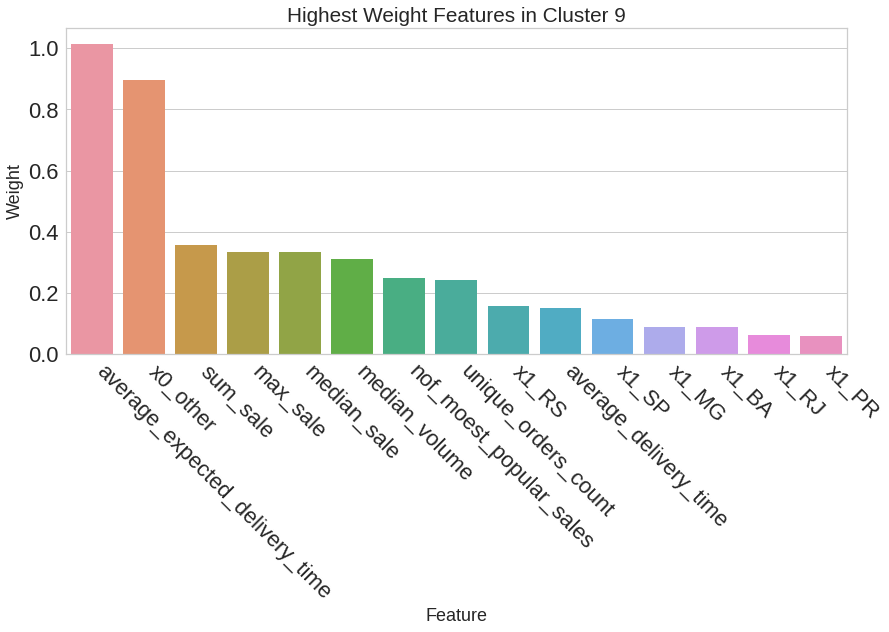

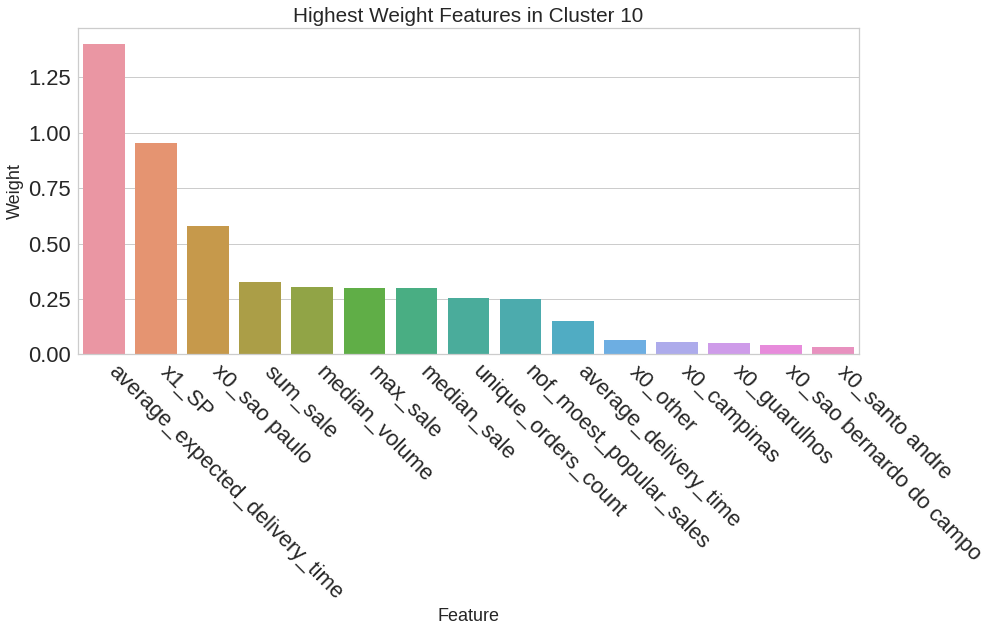

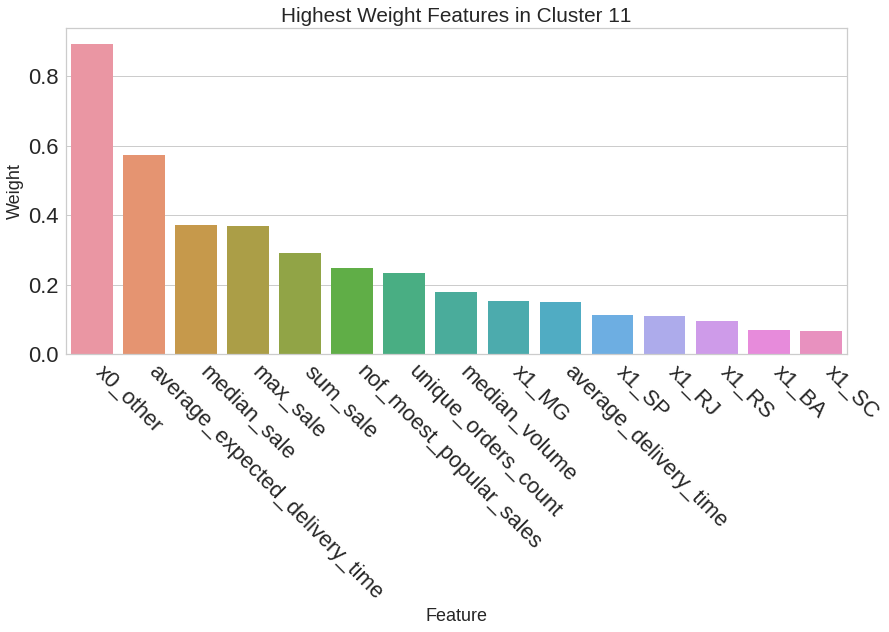

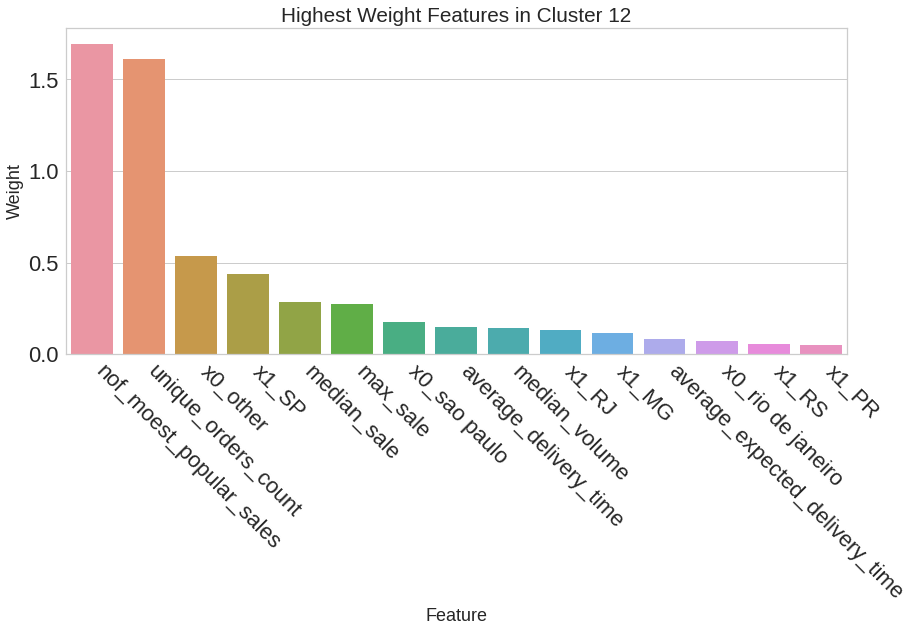

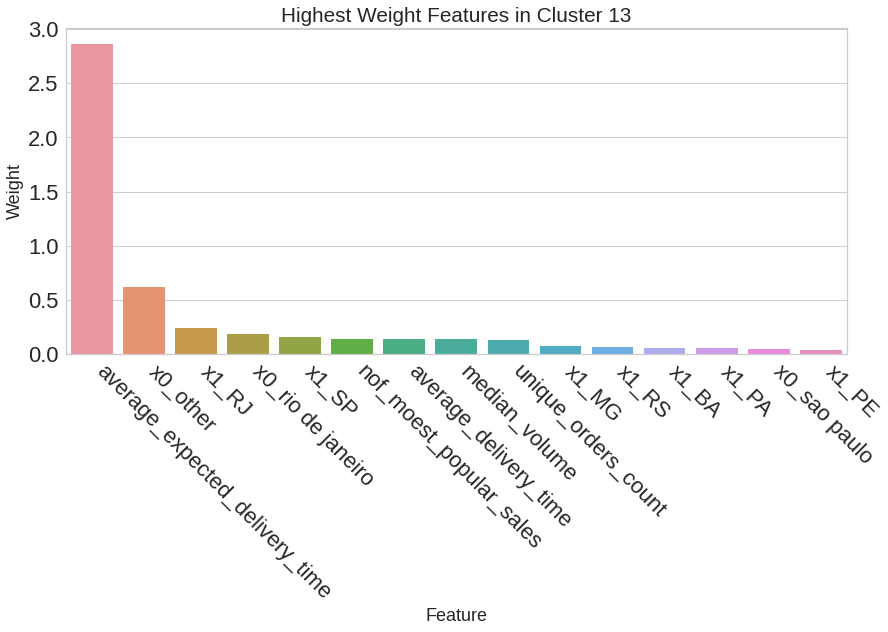

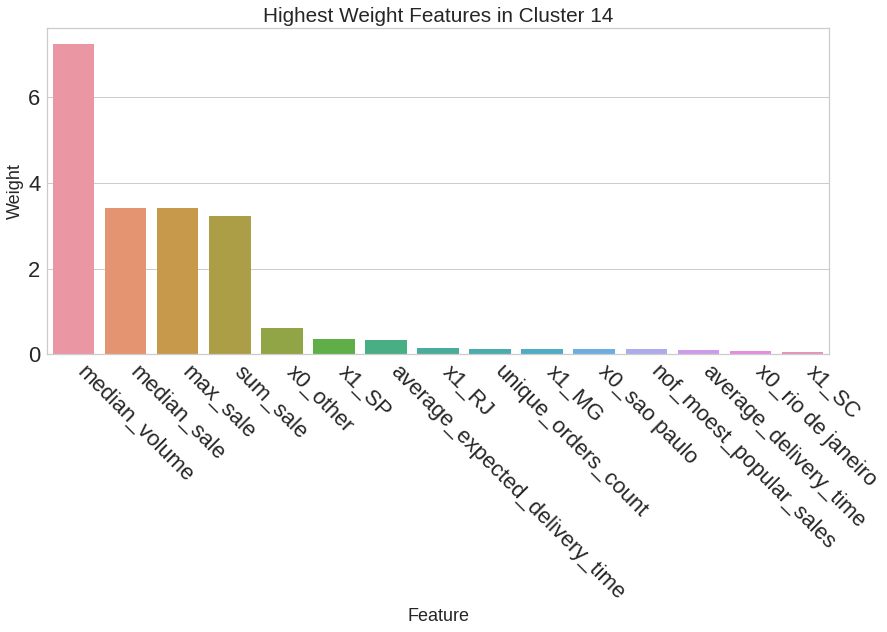

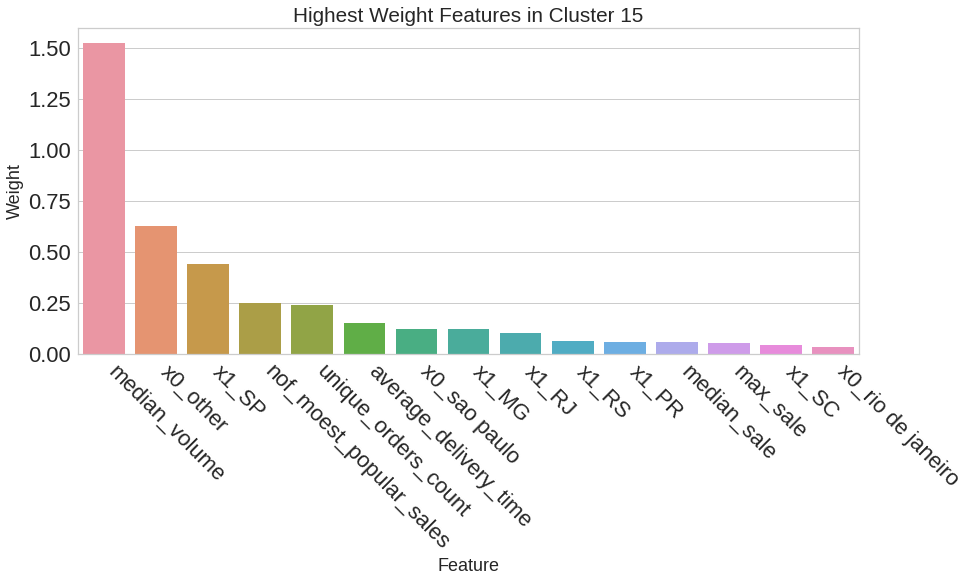

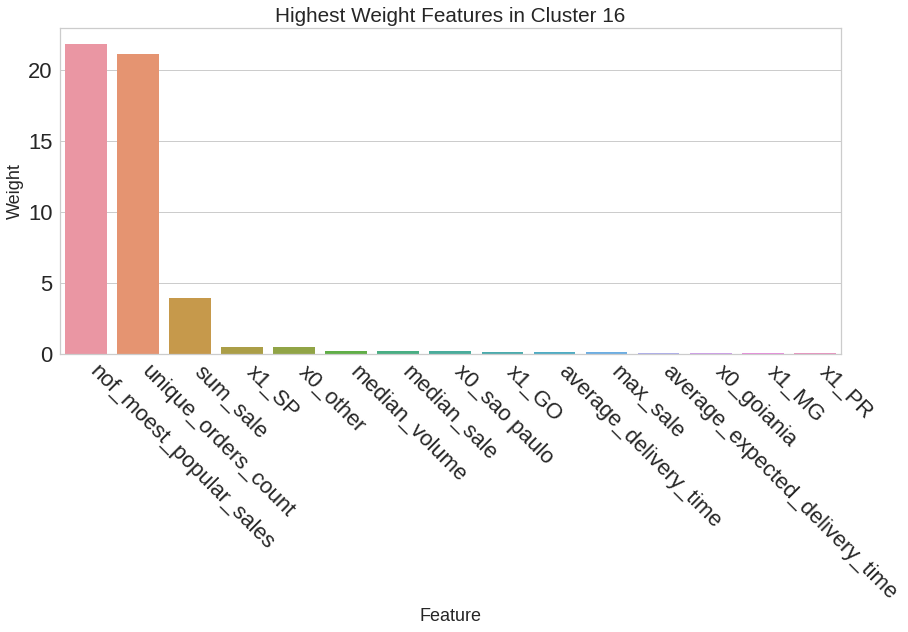

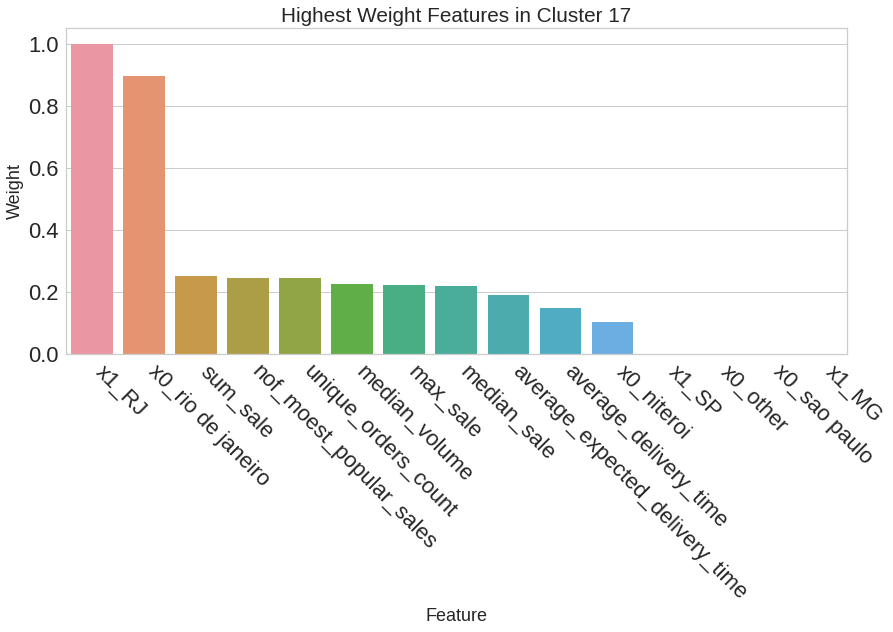

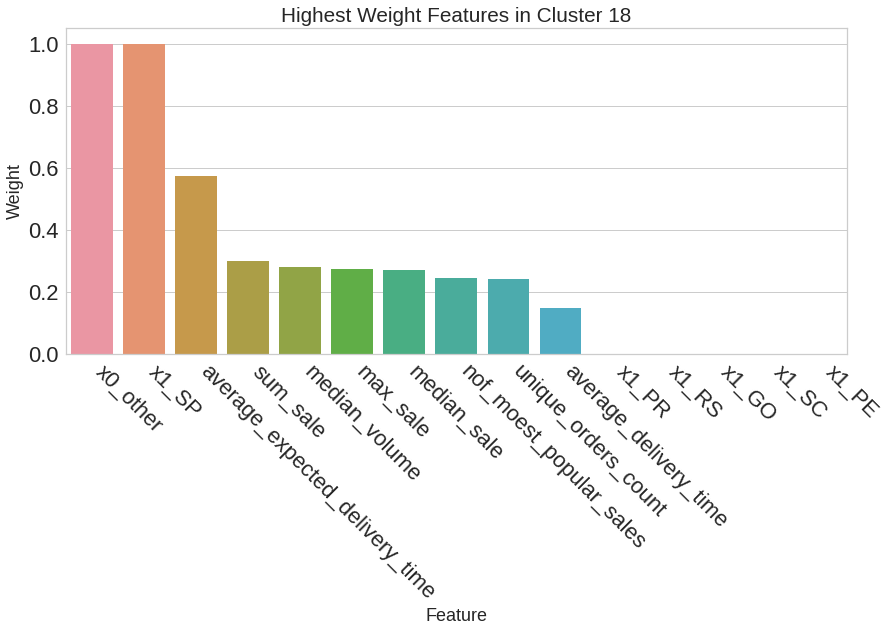

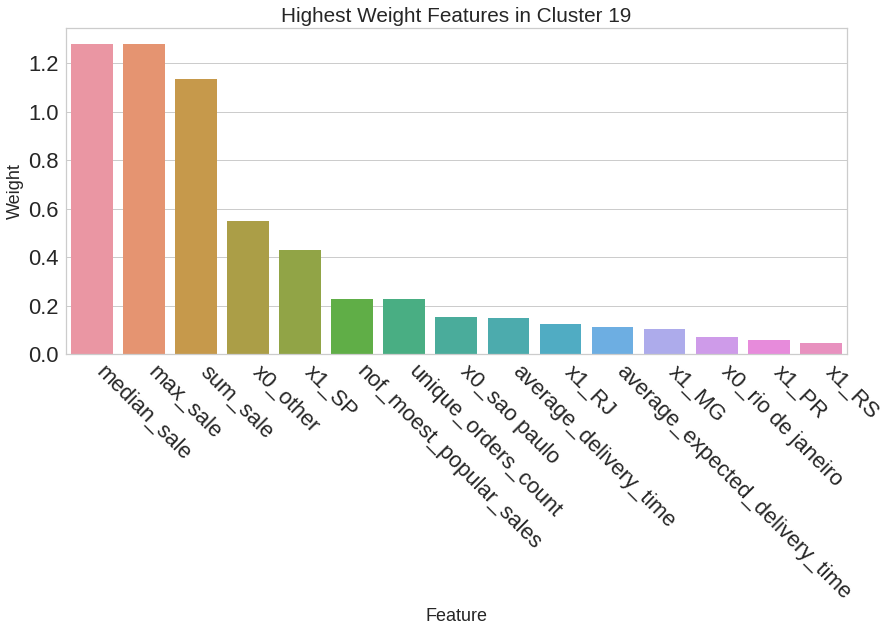

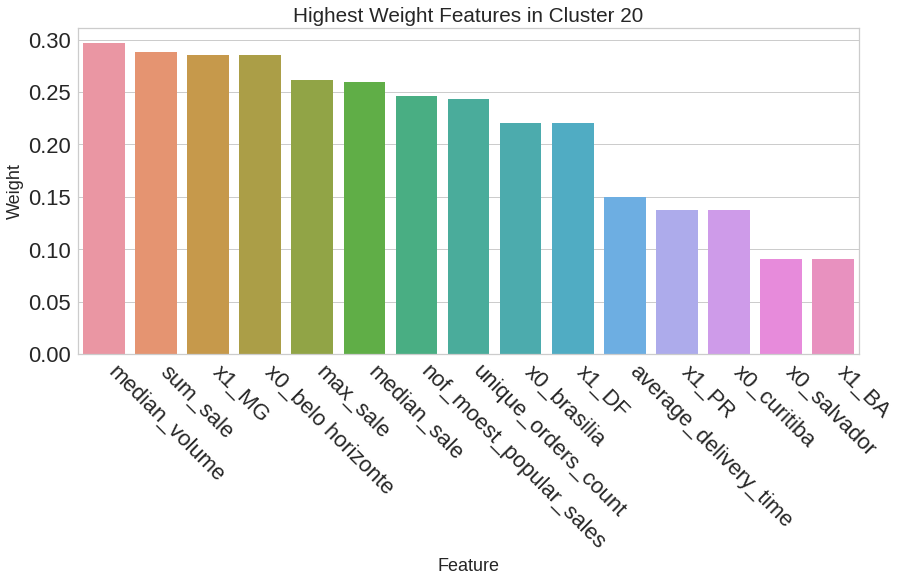

In [166]:
for cluster_label, feature_weights in interpreter.feature_importances_.items():    
    df_feature_weight = pd.DataFrame(feature_weights[:15], columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left");
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Highest Weight Features in Cluster {cluster_label}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize=18)
    plt.ylabel('Weight', fontsize=18)

    plt.show();
    
    print('\n\n')